<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMDB-Movie-Review-Sentiment-Classification" data-toc-modified-id="IMDB-Movie-Review-Sentiment-Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMDB Movie Review Sentiment Classification</a></span></li><li><span><a href="#Purpose" data-toc-modified-id="Purpose-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Process" data-toc-modified-id="Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Process</a></span></li><li><span><a href="#Configure-notebook-and-import-libraries" data-toc-modified-id="Configure-notebook-and-import-libraries-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Configure notebook and import libraries</a></span></li><li><span><a href="#Examine-the-data" data-toc-modified-id="Examine-the-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Examine the data</a></span></li><li><span><a href="#Cleaning-and-preprocessing" data-toc-modified-id="Cleaning-and-preprocessing-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Cleaning and preprocessing</a></span></li><li><span><a href="#Bag-of-words-feature-creation" data-toc-modified-id="Bag-of-words-feature-creation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Bag-of-words feature creation</a></span></li><li><span><a href="#Model-development" data-toc-modified-id="Model-development-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Model development</a></span><ul class="toc-item"><li><span><a href="#Create-validation-data-set" data-toc-modified-id="Create-validation-data-set-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Create validation data set</a></span></li><li><span><a href="#Initial-pass" data-toc-modified-id="Initial-pass-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Initial pass</a></span></li></ul></li></ul></div>

<h1>IMDB Movie Review Sentiment Classification</h1>

<img style="float: left; margin-right: 15px; width: 30%; height: 30%;" src="images/imdb.jpg" />

# Purpose

The overall goal of this set of write-ups is to explore a number of machine learning algorithms utilizing natural language processing (NLP) to classify the sentiment in a set of IMDB movie reviews.

The specific goals of this write-up include:
1. Define the model development process 
2. Explore and prepare the data
3. Create the initial, simple, baseline NLP regression model to classify IMDB movie review sentiments

This series of write-ups is inspired by the Kaggle [
Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial) competition.    

Dataset source:  [IMDB Movie Reviews](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)

# Process

We'll utilize the following process to guide us through this and the following write-ups on the IDMB movie review dataset:

1. Problem definition
2. Evaluation Strategy
3. Baseline model(s)
4. Data validation
5. Model development

# Configure notebook and import libraries

In [143]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import set_option

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# http://www.nltk.org/index.html
# pip install nltk
import nltk
from nltk.corpus import stopwords

# https://www.crummy.com/software/BeautifulSoup/bs4/doc/
# pip install BeautifulSoup4
from bs4 import BeautifulSoup

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
seed = 10
np.random.seed(seed)

# Opens a GUI that allows us to download the NLTK data
#nltk.download()

dataPath = os.path.join('.', 'datasets', 'imdb_movie_reviews')
labeledTrainData = os.path.join(dataPath, 'labeledTrainData.tsv')

# Examine the data

If we open the training data file in a text editor we can see that:
* A header row exists with the values 'id	sentiment	review'
* The values appear to be separated by tabs
* There are double quotes around the review text as well as within the contents of the review text

Based on the last point we'll tell Pandas to avoid quoting with the parameter `quoting = 3`.

Let's go ahead and read the test data file into a Pandas DataFrame and then explore the raw data.

In [126]:
df = pd.read_csv(labeledTrainData, sep = '\t', header = 0, quoting = 3)

##### Shape and data types

In [127]:
df.shape

(25000, 3)

In [128]:
df.dtypes

id           object
sentiment    int64 
review       object
dtype: object

##### Inspect a sub sample of the raw data

In [129]:
# Don't truncate
pd.set_option('display.max_colwidth', -1)
df[8:11].head()

,id,sentiment,review
8,"""319_1""",0,"""A friend of mine bought this film for £1, and even then it was grossly overpriced. Despite featuring big names such as Adam Sandler, Billy Bob Thornton and the incredibly talented Burt Young, this film was about as funny as taking a chisel and hammering it straight through your earhole. It uses tired, bottom of the barrel comedic techniques - consistently breaking the fourth wall as Sandler talks to the audience, and seemingly pointless montages of 'hot girls'.<br /><br />Adam Sandler plays a waiter on a cruise ship who wants to make it as a successful comedian in order to become successful with women. When the ship's resident comedian - the shamelessly named 'Dickie' due to his unfathomable success with the opposite gender - is presumed lost at sea, Sandler's character Shecker gets his big break. Dickie is not dead, he's rather locked in the bathroom, presumably sea sick.<br /><br />Perhaps from his mouth he just vomited the worst film of all time."""
9,"""8713_10""",1,"""<br /><br />This movie is full of references. Like \""Mad Max II\"", \""The wild one\"" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."""
10,"""2486_3""",0,"""What happens when an army of wetbacks, towelheads, and Godless Eastern European commies gather their forces south of the border? Gary Busey kicks their butts, of course. Another laughable example of Reagan-era cultural fallout, Bulletproof wastes a decent supporting cast headed by L Q Jones and Thalmus Rasulala."""


It appears there is a lot of noise in the `review` column we are going to have to deal with:  punctuation, html, escaped double quotes, currency symbols, and so forth.  

Two of the reviews seem to have a clear sentiment, which will hopefully allow the model to train and learn well against:
* Row 8 :: "This movie is a masterpiece." --> Clearly positive
* Row 10 :: "... the worst film of all time." --> Clearly negative

And then we have Row[10] which even as a human I wouldn't be 100% sure if they were being negative and/or sarcastic but in a positive or snarky way.  I would assume this type of review is going to give our learning algorithm some issues.

##### Label distribution

In [130]:
df.groupby('sentiment').size()

sentiment
0    12500
1    12500
dtype: int64

We have an even split of likes and dislikes; no one classification has a skewed representation in the data set.

##### ID distribution

Kaggle's site has this to say about the ID column:
* id - Unique ID of each review

It isn't clear; however, if each review is from a unique author, or we have potentially multiple reviews written by the same person.

It appears that perhaps the first part of the ID before the underscore might identify the author, and the second part of the ID after the underscore might be the Nth review from that author.

We can explore this theory using Pandas:

In [131]:
# Check for dupes against the raw ID values
df['id'].value_counts().shape

(25000,)

In [132]:
# Split the ID on the underscore
split = df['id'].str.replace('"', '').str.split('_')

# Take a look at a sample
split.head(1)

0    [5814, 8]
Name: id, dtype: object

In [133]:
# Pull out the first part of the ID values using a list comprehension, and place results into a Pandas Series object
ids = pd.Series([x[0] for x in split])

# Let's see if the number of records has changed
print("Shape:\n", ids.value_counts(ascending = False).shape, "\n")
print("First five:\n", ids.value_counts(ascending = False).head(5), "\n")
print("Last five:\n", ids.value_counts(ascending = False).tail(5), "\n")

Shape:
 (12500,) 

First five:
 1253    2
132     2
6698    2
8472    2
83      2
dtype: int64 

Last five:
 9994    2
590     2
1990    2
5863    2
6059    2
dtype: int64 



If our theory is correct--which it may not be--then each review author has exactly two entries present in the training observations.  This still provides us with a wide range (12500 in fact) of writing styles, word compositions, and so forth.  It also mitigates the possibility that we might have a few authors with a large number of reviews that would skew the algorithm's ability to generalize to unseen observations.

If our theory is incorrect then we simply have 25,000 unique reviews each written by a different author, and this can only help the model to generalize.

Just for fun; however, let's pick out two reviews by the same author, and see if the writing styles are similar:

In [134]:
samples = df[ df['id'].str.contains('12486_') ]
pd.set_option('display.max_colwidth', -1)
samples

,id,sentiment,review
10936,"""12486_2""",0,"""Rich ditzy Joan Winfield (a woefully miscast Bette Davis) is engaged to be married to stupid egotistical Allen Brice (Jack Carson looking lost). Her father (Eugene Palette) is determined to stop the marriage and has her kidnapped by pilot Steve Collins (James Cagney. Seriously). They crash land in the desert and hate each other but (sigh) start falling in love.<br /><br />This seems to be getting a high rating from reviewers here only because Cagney and Davis are in it. They were both brilliant actors but they were known for dramas NOT comedy and this movie shows why! The script is just horrible--there's not one genuine laugh in the entire movie. The running joke in this has Cagney and Davis falling rump first in a cactus (this is done THREE TIMES!). Only their considerable talents save them from being completely humiliated. As it is they both do their best with the lousy material. Cagney tries his best with his lines and Davis screeches every line full force but it doesn't work. Carson has this \""what the hell\"" look on his face throughout the entire movie (probably because his characters emotions change in seconds). Only Palette with his distinctive voice and over the top readings manges to elicit a few smiles. But, all in all, this was dull and laughless--a real chore to sit through. This gets two stars only for Cagney and Davis' acting and some beautiful cinematography but really--it's not worth seeing. Cagney and Davis hated this film in later years and you can see why."""
11427,"""12486_7""",1,"""Well, this film is a difficult one really. To be straight with you, this film doesn't contain much of a riveting story, nore does it make u 'want' to know how it'll end...but I'll tell you something now...never have I been as tense and jumped up before in my life! This film sure does deliver the jumps and thrills! To be fair, I did watch it at almost midnight so I was kinda sleepy anyway, so maybe that explains why I was jumpy...or maybe it's because this film does deliver in that aspect! It's basically about a couple who lose their child in a tragic event. They decide to move away and rent a cabin looking thing in the mountains...all looks peaceful and calm until they have their first visitors (i think it's it's the sister of the main character, and she brings along her husband)...during the night, the husband hears noises...checks it out, and thats when things start to go really really wrong...they don't stay for another day and tell the couple they should leave asap as something isn't right...to cut a long story short...eventually they find out what has happened in that house in the past few years and decide it needs to be taken care of.<br /><br />It's not a Hollywood blockbuster, nore does it have a huge budget, but please don't let that put you off. It's creepy, tense and very very jumpy! Just give it a try :)"""


Based on the writing styles present in the two samples above the theory that these were written by the same author seems to be weakened.  For example, the second sample utilizes '...' a number of times, but we don't see that present in the first sample.  Likewise the first sample uses all uppercase characters for emphasis, but there are none present in the second sample.  And finally, the use (or misuse) of grammar does not match between the two entries either.

We can also examine the second part of the ID column and look for patterns:

In [14]:
# Pull out the second part of the ID values using a list comprehension, and place results into a Pandas Series object
ids = pd.Series([x[1] for x in split])

#Examine the distribution
print(ids.value_counts().to_string())

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263


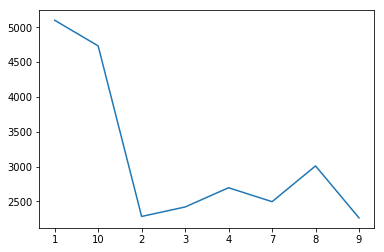

In [15]:
# Visually inspect the distribution
plt.plot(ids.value_counts().sort_index(ascending = True, inplace = False))

There really doesn't see to be a meaningful pattern here, so we'll move on.

# Cleaning and preprocessing

Now that we have a handle on what the data looks like we can begin the cleaning and preprocessing.  Since we are going to implement a [`bag-of-words model`](https://en.wikipedia.org/wiki/Bag-of-words_model) (covered in more detail below) we want to turn each review into a collection of individual words.  

So, first let's find a "messy" review full of HTML, punctuation, and other items we can review as we apply each step of the cleaning, and see how things are going.

In [36]:
messy = df.loc[ df['id'] == '"9170_1"', 'review'].to_string()
messy

'108    "The question, when one sees a movie this bad, is not necessarily, \\"How did a movie this bad get made?\\" or even, \\"Why did I see this awful in the first place?\\" but, \\"What have I learned from this experience?\\" Here\'s what I learned:<br /><br />- Just because the \\"rules\\" of horror movies have been catalogued and satirized countless times in the last ten years doesn\'t mean someone won\'t go ahead and make a movie that uses ALL of them, without a shred of humor or irony.<br /><br />- If your movie has to be described as **loosely** based on the video game, you have script problems.<br /><br />- The black character may not always die first, but the Asian character does always know kung-fu.<br /><br />- While you may be proud that you figured out how to do the \\"the Matrix effect\\" on a budget, that doesn\'t necessarily mean you should use it over and over again ad nausea.<br /><br />- Being Ron Howard\'s brother does not guarantee choice roles.<br /><br />- Whene

This one looks like a good candidate.  First, let's deal with the HTML:

In [37]:
clean = BeautifulSoup(messy)
clean.get_text()

'108    "The question, when one sees a movie this bad, is not necessarily, \\"How did a movie this bad get made?\\" or even, \\"Why did I see this awful in the first place?\\" but, \\"What have I learned from this experience?\\" Here\'s what I learned:- Just because the \\"rules\\" of horror movies have been catalogued and satirized countless times in the last ten years doesn\'t mean someone won\'t go ahead and make a movie that uses ALL of them, without a shred of humor or irony.- If your movie has to be described as **loosely** based on the video game, you have script problems.- The black character may not always die first, but the Asian character does always know kung-fu.- While you may be proud that you figured out how to do the \\"the Matrix effect\\" on a budget, that doesn\'t necessarily mean you should use it over and over again ad nausea.- Being Ron Howard\'s brother does not guarantee choice roles.- Whenever a scene doesn\'t edit together, just use some footage from the video

Next we'll remove anything that's not a letter.  This is overly simplistic; however, as sometimes punctuation could imply sentiment.  We'll address this in later iterations.

In [38]:
clean = re.sub("[^a-zA-Z]", ' ', clean.get_text())
clean

'        The question  when one sees a movie this bad  is not necessarily    How did a movie this bad get made    or even    Why did I see this awful in the first place    but    What have I learned from this experience    Here s what I learned   Just because the   rules   of horror movies have been catalogued and satirized countless times in the last ten years doesn t mean someone won t go ahead and make a movie that uses ALL of them  without a shred of humor or irony   If your movie has to be described as   loosely   based on the video game  you have script problems   The black character may not always die first  but the Asian character does always know kung fu   While you may be proud that you figured out how to do the   the Matrix effect   on a budget  that doesn t necessarily mean you should use it over and over again ad nausea   Being Ron Howard s brother does not guarantee choice roles   Whenever a scene doesn t edit together  just use some footage from the video game  no one wi

This is already starting to look much better.  However, we have a number of "words" such as 've' and 't' floating around in the next now.  This is from the punctuation in words such as "I've" and "won't" being removed.  These will be taken care of when we remove the stop words below.

Next let's convert everything to lower case and tokenize the the review:

In [39]:
clean = clean.lower().split()
print(list(clean))

['the', 'question', 'when', 'one', 'sees', 'a', 'movie', 'this', 'bad', 'is', 'not', 'necessarily', 'how', 'did', 'a', 'movie', 'this', 'bad', 'get', 'made', 'or', 'even', 'why', 'did', 'i', 'see', 'this', 'awful', 'in', 'the', 'first', 'place', 'but', 'what', 'have', 'i', 'learned', 'from', 'this', 'experience', 'here', 's', 'what', 'i', 'learned', 'just', 'because', 'the', 'rules', 'of', 'horror', 'movies', 'have', 'been', 'catalogued', 'and', 'satirized', 'countless', 'times', 'in', 'the', 'last', 'ten', 'years', 'doesn', 't', 'mean', 'someone', 'won', 't', 'go', 'ahead', 'and', 'make', 'a', 'movie', 'that', 'uses', 'all', 'of', 'them', 'without', 'a', 'shred', 'of', 'humor', 'or', 'irony', 'if', 'your', 'movie', 'has', 'to', 'be', 'described', 'as', 'loosely', 'based', 'on', 'the', 'video', 'game', 'you', 'have', 'script', 'problems', 'the', 'black', 'character', 'may', 'not', 'always', 'die', 'first', 'but', 'the', 'asian', 'character', 'does', 'always', 'know', 'kung', 'fu', 'whi

And we'll also remove any English stop words:

In [40]:
# Examine the list of English stop words from the NLTK stop word dictionary
print(stopwords.words("english")) 

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [41]:
# Use a list comprehension to remove any stop words from the 'clean' review
# Convert the stop words to a set object to optimize search speed
clean = [x for x in clean if not x in set(stopwords.words("english"))]

# Review the final, clean review
clean = " ".join(clean)
print(clean)

question one sees movie bad necessarily movie bad get made even see awful first place learned experience learned rules horror movies catalogued satirized countless times last ten years mean someone go ahead make movie uses without shred humor irony movie described loosely based video game script problems black character may always die first asian character always know kung fu may proud figured matrix effect budget necessarily mean use ad nausea ron howard brother guarantee choice roles whenever scene edit together use footage video game one notice cousin rap metal band offers write movie theme free politely decline zombie movies people killing zombies zombies killing people preferably gruesome way possible makes scary white people pay get rave deserve die find old book tell everything need know anything else figure two lines someone asks bare breasts horror movie panacea helicopter boom shot licensing deal sega magically transforms movie student film major studio release try name drop 

Not bad!  This is definitely cleaner than what we started with.  Next we'll create a function that combines all the manual steps we performed above, and then feed the entire training set of review through it. 

In [42]:
# Convert the stop words to a set
stopWords = set(stopwords.words("english"))

# Clean IMDB review text
def cleanReview(review, stopWords):
    # Remove HTML
    clean = BeautifulSoup(review)
    
    # Remove non-alpha chars
    clean = re.sub("[^a-zA-Z]", ' ', clean.get_text())
    
    # Convert to lower case and "tokenize"
    clean = clean.lower().split()
    
    # Remove stop words
    clean = [x for x in clean if not x in stopWords]

    # Prepare final, cleaned review
    clean = " ".join(clean)
    
    # Return results
    return clean
    

Let's go ahead and test the function on the "messy" review we've been using as our benchmark and ensure it works as expected:

In [63]:
# Feed the "messy" review through the cleaning function
cleanDef = cleanReview(df.loc[ df['id'] == '"9170_1"', 'review'].to_string(), stopWords)

# Assert the function ouputs the same results as "by hand"
assert(cleanDef == clean)

# Examine the output
print(cleanDef)

question one sees movie bad necessarily movie bad get made even see awful first place learned experience learned rules horror movies catalogued satirized countless times last ten years mean someone go ahead make movie uses without shred humor irony movie described loosely based video game script problems black character may always die first asian character always know kung fu may proud figured matrix effect budget necessarily mean use ad nausea ron howard brother guarantee choice roles whenever scene edit together use footage video game one notice cousin rap metal band offers write movie theme free politely decline zombie movies people killing zombies zombies killing people preferably gruesome way possible makes scary white people pay get rave deserve die find old book tell everything need know anything else figure two lines someone asks bare breasts horror movie panacea helicopter boom shot licensing deal sega magically transforms movie student film major studio release try name drop 

And finally we'll run the entire set of training reviews through the cleaning function:

In [64]:
cleanReviews = [cleanReview(x, stopWords) for x in df['review']]
assert(len(df) == (len(cleanReviews)))
assert(clean == cleanReviews[108])

# Bag-of-words feature creation

One of the main goals of this write-up is the initial creating of a simple baseline model we can compare further efforts against.  We are going to do this via a [`bag-of-words model`](https://en.wikipedia.org/wiki/Bag-of-words_model) (BOW).

In short the BOW doesn't care about grammar or word order.  It does; however, care about how many of each word appear in the target corpus.  

> In practice, the Bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the text. The most common type of characteristics, or features calculated from the Bag-of-words model is term frequency, namely, the number of times a term appears in the text. [Source](https://en.wikipedia.org/wiki/Bag-of-words_model)

So in the sample review '9170_1' we were examining above we notice that the word 'bad' appears twice, and the words 'worse' and 'awful' appear once.  It is highly likely that other reviews with a negative rating will also contain these words along with others such as 'hate', 'waste', etc.  In these cases the BOW decide that these reviews are similar and place them in the same 'bag' as review '9170_1' (i.e. a negative review classification).

The Wikipedia article provides another example:
>In Bayesian spam filtering, an e-mail message is modeled as an unordered collection of words selected from one of two probability distributions: one representing spam and one representing legitimate e-mail ("ham"). Imagine that there are two literal bags full of words. One bag is filled with words found in spam messages, and the other bag is filled with words found in legitimate e-mail. While any given word is likely to be found somewhere in both bags, the "spam" bag will contain spam-related words such as "stock", "Viagra", and "buy" much more frequently, while the "ham" bag will contain more words related to the user's friends or workplace.

>To classify an e-mail message, the Bayesian spam filter assumes that the message is a pile of words that has been poured out randomly from one of the two bags, and uses Bayesian probability to determine which bag it is more likely to be.


Scikit-Learn has a [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) module we can utilize to create the 'bags of words' numeric representation of the reviews suitable for the machine learning model.

In [86]:
# Utilize the defaults for the object instantiation other than max_features
vec = CountVectorizer(max_features = 5000)

# Similar to how almost every other Scikit-Learn objects works we'll call the fit() and transform() methods
features = vec.fit_transform(cleanReviews)

# And finally we'll convert to a np.array
features = features.toarray()

print("Features shape: ", features.shape)

Features shape:  (25000, 5000)


Let's examine the first 30 feature entries for review '9170_1'

In [87]:
print(features[108,0:30])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We noticed above that the word 'bad' appeared twice in the review.  Let's confirm the sparse feature matrix (i.e. bag of words) captured this:

In [89]:
# Take a look at the first 10 words in the vocabulary
vocab = vec.get_feature_names()
print(vocab[:10])

['abandoned', 'abc', 'abilities', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely']


In [90]:
# Which index position is 'bad' in?
vocab.index('bad')

323

In [91]:
# How many times did bad appear in review '9170_1'?
features[108,323]

2

So everything appears to check out correctly.  Let's review the most and least occurring words in the 'bag', and then we'll move on to model implementation.

In [121]:
_df = pd.DataFrame(data = features, columns = vocab).sum()
_df.sort_values(ascending = False, inplace = True)

In [122]:
print("Top 10:\n")
print(_df.head(10))

Top 10:

movie     44031
film      40147
one       26788
like      20274
good      15140
time      12724
even      12646
would     12436
story     11983
really    11736
dtype: int64


In [123]:
print("Bottom 10:\n")
print(_df.tail(10))

Bottom 10:

skull       78
sopranos    78
premiere    78
bunny       78
flair       78
fishing     78
awhile      78
stumbled    78
amused      78
cream       78
dtype: int64


Yes, apparently the word 'cream' was used 78 times in the review corpus...

# Model development

We are finally ready to develop the baseline model on the data we've explored, cleaned, and processed.  Because the IMDB data set doesn't include a validation set we'll create one from a portion of the training data.  The processes is similar to our work in previous write-ups such as the [Iris classifier](.//Model-01.ipynb).

## Create validation data set

In [147]:
# Seperate X and Y values
x = features
y = df["sentiment"]

print("x.shape = ", x.shape)
print("y.shape = ", y.shape)

# Split out validation set -- 80/20 split
valSize = 0.2

xTrain, xVal, yTrain, yVal = train_test_split(x, y, test_size = valSize, random_state = seed)

print("--------")
print("xTrain.shape = ", xTrain.shape)
print("yTrain.shape = ", yTrain.shape)
print("xVal.shape = ", xVal.shape)
print("yVal.shape = ", yVal.shape)

x.shape =  (25000, 5000)
y.shape =  (25000,)
--------
xTrain.shape =  (20000, 5000)
yTrain.shape =  (20000,)
xVal.shape =  (5000, 5000)
yVal.shape =  (5000,)


## Initial pass

We'll apply a number of non-ensemble algorithms to the data set to start with.  Scikit-learn makes this very easy to do along with the fact that the data set isn't overly large, and we've already done similar work in previous write-ups we can 'borrow.'

In [ ]:
# Init vars
folds = 10
seed = 10
models = []
results = {}

# Use accuracy since this is a classification
score = 'accuracy'

# Instantiate model objects
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Create a Pandas DF to hold all our spiffy results
_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'StdDev'])

# Run the models
for modelName, model in models:
    print("Training", modelName, "....")
    # Implement K-fold cross validation where K = 10
    kFold = KFold(n_splits = folds, random_state = seed)
    results[modelName] = cross_val_score(model, xTrain, yTrain, cv = kFold, scoring = score)
    _df.loc[len(_df)] = list([modelName, results[modelName].mean(), results[modelName].std()])

# Print results sorted by Mean desc, StdDev asc, Model asc
_df.sort_values(by = ['Accuracy', 'StdDev', 'Model'], ascending = [False, True, True])

Training LR ....

Training LDA ....

Training KNN ....



In [135]:
# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable
#
# This may take a few minutes to run
forest = forest.fit( features, df["sentiment"] )

In [136]:
preds = forest.predict(features)

In [140]:
print("accuracy_score = ", accuracy_score(df["sentiment"], preds), "\n")
print("confusion_matrix\n", confusion_matrix(df["sentiment"], preds), "\n")
print("classification_report\n", classification_report(df["sentiment"], preds))

accuracy_score =  1.0 

confusion_matrix
 [[12500     0]
 [    0 12500]] 

classification_report
              precision    recall  f1-score   support

          0       1.00      1.00      1.00     12500
          1       1.00      1.00      1.00     12500

avg / total       1.00      1.00      1.00     25000

